# ResNet vs Plain CNN — Chest X-Ray Fine-tune (Colab)

This Colab notebook fine-tunes a ResNet backbone (resnet50 / resnet101) and a plain CNN baseline on a Chest X-Ray classification dataset (e.g., NIH ChestX-ray14). It is structured to be runnable in Google Colab with GPU. The notebook:

- clones your GitHub repo (or you can upload dataset manually)
- installs required packages
- prepares dataloaders (example pipeline)
- defines PlainNet and ResNet models
- trains both models and logs metrics (per-epoch CSV)
- plots comparison figures (AUC / loss)

---


In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
!pip install -q timm==0.6.14 torchmetrics scikit-learn pandas seaborn || true
import torch, torchvision
print('torch', torch.__version__, 'torchvision', torchvision.__version__)

ERROR: Could not find a version that satisfies the requirement timm==0.6.14 (from versions: 0.1.1, 0.1.2, 0.1.4, 0.1.6, 0.1.8, 0.1.10, 0.1.12, 0.1.14, 0.1.16, 0.1.18, 0.1.20, 0.1.22, 0.1.24, 0.1.26, 0.1.28, 0.1.30, 0.2.1, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 0.3.4, 0.4.5, 0.4.9, 0.4.12, 0.5.4, 0.6.2.dev0, 0.6.5, 0.6.7, 0.6.11, 0.6.12, 0.6.13, 0.8.0.dev0, 0.8.2.dev0, 0.8.3.dev0, 0.8.6.dev0, 0.8.10.dev0, 0.8.11.dev0, 0.8.13.dev0, 0.8.15.dev0, 0.8.17.dev0, 0.8.19.dev0, 0.8.21.dev0, 0.8.23.dev0, 0.9.0, 0.9.1, 0.9.2, 0.9.5, 0.9.6, 0.9.7, 0.9.8, 0.9.9, 0.9.10, 0.9.11, 0.9.12, 0.9.16, 1.0.3, 1.0.7, 1.0.8, 1.0.9, 1.0.10, 1.0.11, 1.0.12, 1.0.13, 1.0.14, 1.0.15, 1.0.16, 1.0.17, 1.0.18, 1.0.19, 1.0.20)
ERROR: No matching distribution found for timm==0.6.14
torch 2.8.0+cu126 torchvision 0.23.0+cu126


## 1) Clone your GitHub repo (optional)

If you want to use the dataset and helper utilities in your `Chest-X-Ray-Classification` repo, run the cell below. Otherwise, upload your data to the Colab session or mount Google Drive and set `DATA_DIR` accordingly.

In [58]:
!git clone https://github.com/Adhini99/Chest-X-Ray-Classification.git repo_cxr || true
!ls -la repo_cxr | sed -n '1,120p'

fatal: destination path 'repo_cxr' already exists and is not an empty directory.
total 11056
drwxr-xr-x 3 root root    4096 Sep 25 04:49 .
drwxr-xr-x 1 root root    4096 Sep 25 04:54 ..
-rw-r--r-- 1 root root 2649185 Sep 25 04:49 Copy_of_Chest_X_Ray_Classification_with_Dense_and_Swin.ipynb
-rw-r--r-- 1 root root 8647116 Sep 25 04:49 Copy_of_Chest_X_Ray_Vit_Classification.ipynb
drwxr-xr-x 8 root root    4096 Sep 25 04:49 .git
-rw-r--r-- 1 root root    2207 Sep 25 04:49 README.md
-rw-r--r-- 1 root root    1287 Sep 25 04:49 README.VIT


## 2) Configuration

Set dataset paths and basic hyperparameters below. If you mounted Google Drive or uploaded data, change `DATA_DIR` to point there. For a quick demo set `FAST_DEBUG=True` to use a small subset and few epochs.

In [59]:
# Use KaggleHub dataset path instead of repo folder
import kagglehub

# Download & cache NIH Chest X-ray 14 (224x224 resized)
DATA_DIR = kagglehub.dataset_download('khanfashee/nih-chest-x-ray-14-224x224-resized')

# Quick debug mode (use smaller batch & fewer epochs)
FAST_DEBUG = True      # set False for full training

# Dataset settings
NUM_CLASSES = 14       # NIH dataset has 14 disease labels
IMAGE_SIZE = 224       # images are pre-resized to 224x224
BATCH_SIZE = 32 if not FAST_DEBUG else 8
EPOCHS = 20 if not FAST_DEBUG else 3

# Hardware setup
import torch, random, numpy as np
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 42

print("DATA_DIR:", DATA_DIR)
print("DEVICE:", DEVICE)

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)



DATA_DIR: /root/.cache/kagglehub/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/versions/3
DEVICE: cuda


### 3) Dataset helper

This cell provides a lightweight Dataset class that expects a CSV with columns `image_path` and multi-hot label columns (0/1 per class). If your repo already has a dataset loader, replace this cell with your loader.

In [60]:
class CXRDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None, image_col='image_path', label_cols=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transforms = transforms
        self.image_col = image_col
        self.label_cols = label_cols
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row[self.image_col])
        from PIL import Image
        img = Image.open(img_path).convert('RGB')
        if self.transforms:
            img = self.transforms(img)
        if self.label_cols is not None:
            labels = row[self.label_cols].values.astype('float32')
            labels = torch.from_numpy(labels)
        else:
            labels = torch.zeros(NUM_CLASSES, dtype=torch.float32)
        return img, labels


In [61]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.485,0.485], std=[0.229,0.229,0.229])
])
val_transforms = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.14)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.485,0.485], std=[0.229,0.229,0.229])
])

In [62]:
# Try to locate a labels CSV in the cloned repo; otherwise create a tiny synthetic example for demo
labels_csv = None
for root, dirs, files in os.walk('repo_cxr'):
    for f in files:
        if 'labels' in f.lower() and f.lower().endswith('.csv'):
            labels_csv = os.path.join(root, f)
            break
    if labels_csv:
        break

if labels_csv and os.path.exists(labels_csv):
    print('Found labels CSV:', labels_csv)
    df_all = pd.read_csv(labels_csv)
    display(df_all.head())
else:
    print('No labels CSV found. Creating a tiny synthetic dataset for demo.')
    os.makedirs('/content/demo_imgs', exist_ok=True)
    from PIL import Image, ImageDraw
    demo_rows = []
    for i in range(40):
        img = Image.new('RGB',(256,256),(int(255*i/40),0,0))
        draw = ImageDraw.Draw(img)
        draw.text((10,10), f"img{i}", fill=(255,255,255))
        p = f'demo_{i}.png'
        img.save(os.path.join('/content/demo_imgs', p))
        labels = np.random.randint(0,2, size=(NUM_CLASSES,))
        row = {'image_path': p}
        for j in range(NUM_CLASSES):
            row[f'label_{j}'] = labels[j]
        demo_rows.append(row)
    df_all = pd.DataFrame(demo_rows)
    df_all.to_csv('/content/demo_labels.csv', index=False)
    labels_csv = '/content/demo_labels.csv'
    print('Demo labels saved to', labels_csv)

label_cols = [c for c in df_all.columns if c != 'image_path']
if len(label_cols) == 0:
    print('No label columns detected; you will need to adjust this cell to your CSV format.')
else:
    print('Detected label columns:', label_cols[:6])

No labels CSV found. Creating a tiny synthetic dataset for demo.
Demo labels saved to /content/demo_labels.csv
Detected label columns: ['label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5']


In [63]:
from sklearn.model_selection import train_test_split
import os
if 'image_path' not in df_all.columns:
    raise RuntimeError('CSV does not contain image_path column. Update cell to match your CSV format.')

# Determine the correct image directory based on whether a demo dataset was created
img_directory = '/content/demo_imgs' if os.path.exists('/content/demo_imgs') else DATA_DIR

train_df, val_df = train_test_split(df_all, test_size=0.2, random_state=SEED, shuffle=True)
train_ds = CXRDataset(train_df, img_dir=img_directory, transforms=train_transforms, image_col='image_path', label_cols=label_cols)
val_ds = CXRDataset(val_df, img_dir=img_directory, transforms=val_transforms, image_col='image_path', label_cols=label_cols)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)

print('Train samples:', len(train_ds), 'Val samples:', len(val_ds))

Train samples: 32 Val samples: 8


In [64]:
# PlainNet and ResNet definitions
class PlainNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1,bias=False), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32,32,3,padding=1,bias=False), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1,bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64,64,3,padding=1,bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1,bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128,128,3,padding=1,bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(128, num_classes)
    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

def get_resnet(name='resnet50', pretrained=True, num_classes=NUM_CLASSES):
    if name.startswith('resnet'):
        model = models.__dict__[name](pretrained=pretrained)
        in_f = model.fc.in_features
        model.fc = nn.Linear(in_f, num_classes)
    else:
        model = timm.create_model(name, pretrained=pretrained, num_classes=num_classes)
    return model

print('Models instantiated examples:')
_ = PlainNet()
_ = get_resnet('resnet50', pretrained=False, num_classes=NUM_CLASSES)
print('Done')

Models instantiated examples:


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Done


In [65]:
# Training utilities
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    all_logits, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            all_logits.append(torch.sigmoid(logits).cpu().numpy())
            all_labels.append(labels.numpy())
    if len(all_logits)==0:
        return None, None
    all_logits = np.concatenate(all_logits, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    aucs = []
    for i in range(all_labels.shape[1]):
        try:
            auc = roc_auc_score(all_labels[:,i], all_logits[:,i])
        except Exception:
            auc = np.nan
        aucs.append(auc)
    mean_auc = np.nanmean(aucs)
    return mean_auc, aucs


In [66]:
def run_training(model, train_loader, val_loader, epochs=EPOCHS, lr=1e-3, save_prefix='model'):
    model = model.to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.5*epochs), int(0.75*epochs)], gamma=0.1)
    history = {'epoch':[], 'train_loss':[], 'val_mean_auc':[]}
    best_auc = -1
    for ep in range(1, epochs+1):
        t0 = time.time()
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_mean_auc, val_aucs = evaluate(model, val_loader, DEVICE)
        scheduler.step()
        history['epoch'].append(ep)
        history['train_loss'].append(train_loss)
        history['val_mean_auc'].append(val_mean_auc)
        print(f'Epoch {ep}/{epochs} train_loss {train_loss:.4f} val_mean_auc {val_mean_auc:.4f} time {(time.time()-t0):.1f}s')
        if val_mean_auc and val_mean_auc > best_auc:
            best_auc = val_mean_auc
            torch.save(model.state_dict(), f'{save_prefix}_best.pth')
    pd.DataFrame(history).to_csv(f'{save_prefix}_history.csv', index=False)
    return history, best_auc


In [67]:
# Run experiments (demo)
plain = PlainNet(num_classes=NUM_CLASSES)
hist_plain, best_plain = run_training(plain, train_loader, val_loader, epochs=EPOCHS, lr=1e-3, save_prefix='plainnet')
print('Plain best mean AUC', best_plain)

resnet = get_resnet('resnet50', pretrained=True, num_classes=NUM_CLASSES)
hist_resnet, best_resnet = run_training(resnet, train_loader, val_loader, epochs=EPOCHS, lr=1e-3, save_prefix='resnet50')
print('ResNet best mean AUC', best_resnet)


Epoch 1/3 train_loss 0.6994 val_mean_auc 0.4798 time 3.5s
Epoch 2/3 train_loss 0.6996 val_mean_auc 0.4580 time 0.7s
Epoch 3/3 train_loss 0.7005 val_mean_auc 0.4440 time 0.7s
Plain best mean AUC 0.4797619047619048


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


Epoch 1/3 train_loss 0.6992 val_mean_auc 0.4815 time 0.9s
Epoch 2/3 train_loss 0.6929 val_mean_auc 0.4792 time 0.7s
Epoch 3/3 train_loss 0.6944 val_mean_auc 0.4866 time 0.7s
ResNet best mean AUC 0.48660714285714285


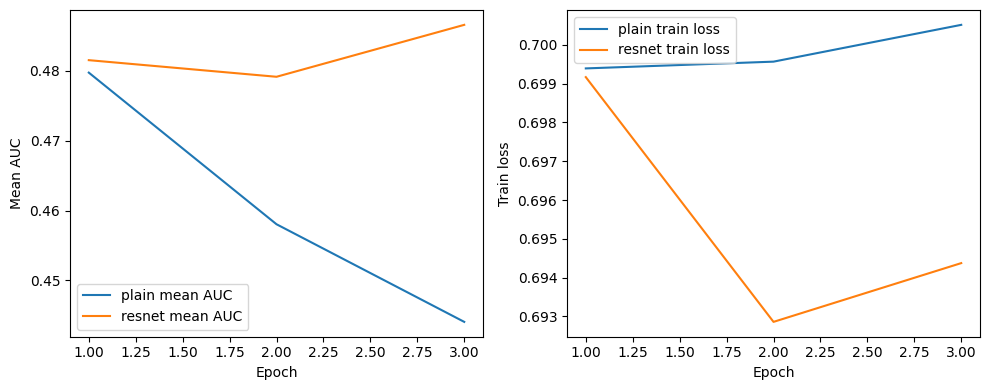

Saved comparison_cxr.png


In [68]:
import pandas as pd
if os.path.exists('plainnet_history.csv') and os.path.exists('resnet50_history.csv'):
    df_plain = pd.read_csv('plainnet_history.csv')
    df_res = pd.read_csv('resnet50_history.csv')
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(df_plain['epoch'], df_plain['val_mean_auc'], label='plain mean AUC')
    plt.plot(df_res['epoch'], df_res['val_mean_auc'], label='resnet mean AUC')
    plt.xlabel('Epoch'); plt.ylabel('Mean AUC'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(df_plain['epoch'], df_plain['train_loss'], label='plain train loss')
    plt.plot(df_res['epoch'], df_res['train_loss'], label='resnet train loss')
    plt.xlabel('Epoch'); plt.ylabel('Train loss'); plt.legend()
    plt.tight_layout()
    plt.savefig('comparison_cxr.png')
    plt.show()
    print('Saved comparison_cxr.png')
else:
    print('History files not found - run training cells first')